<a href="https://colab.research.google.com/github/rhozon/Banca-FAE/blob/master/NotebookRL_politicsforming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
#@title Instalação de Dependências

!pip install --quiet yahooquery stable-baselines3 gymnasium shimmy


In [44]:
#@title Imports e Ambiente

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from yahooquery import Ticker
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy


In [71]:
#@title Set dos tickers de cada grupo (trocar pros seus)

# Hiperparâmetros gerais
TICKERS         = ["ZC=F","ZO=F","KE=F","GF=F","ZS=F","ZM=F","ZL=F"]
WINDOW_SIZE     = 20
TRANSACTION_COST= 0.001
INITIAL_BALANCE = 100_000.0
SEED            = 42

# Parâmetros de treino
TOTAL_TIMESTEPS = 100_000
COOLDOWN_DAYS   = 3   # agora 3 dias de cooldown
PENALTY_COEF    = 0.5 # coeficiente de penalização de drawdown, se usado

# Reward shapes suportados: "pnl", "log_return", "drawdown_penalty"
REWARD_TYPE     = "log_return"

class TradingEnv(gym.Env):
    """Ambiente RL com cooldown e reward shape configurável."""
    metadata = {"render_modes": ["human"], "render_fps": 1}
    def __init__(self, series: pd.Series):
        super().__init__()
        self.dates  = list(series.index)
        self.prices = series.values
        self.window = WINDOW_SIZE
        self.tc     = TRANSACTION_COST
        self.cool   = COOLDOWN_DAYS

        self.action_space = spaces.Discrete(3)  # hold/buy/sell
        self.observation_space = spaces.Box(
            low=-1, high=1, shape=(self.window-1,), dtype=np.float32
        )

    def reset(self, **kwargs):
        super().reset(**kwargs)
        self.i      = self.window-1
        self.balance= INITIAL_BALANCE
        self.pos    = 0
        self.last_t = -self.cool
        self.peak   = INITIAL_BALANCE
        return self._state(), {}

    def _state(self):
        seg     = self.prices[self.i-self.window+1:self.i+1]
        returns = np.diff(seg)/seg[:-1]
        return np.clip(returns, -1, 1).astype(np.float32)

    def step(self, action):
        price        = float(self.prices[self.i])
        total_before = self.balance + self.pos*price

        # executa só se cooldown ok
        if self.i - self.last_t >= self.cool:
            if action==1 and self.balance>=price*(1+self.tc):
                self.pos   += 1
                self.balance -= price*(1+self.tc)
                self.last_t= self.i
            elif action==2 and self.pos>0:
                self.pos   -= 1
                self.balance += price*(1-self.tc)
                self.last_t= self.i

        self.i += 1
        done = self.i>=len(self.prices)

        # finaliza posição
        if done and self.pos>0:
            self.balance += self.pos*price*(1-self.tc)
            self.pos = 0

        price_after  = float(self.prices[self.i-1] if done else self.prices[self.i])
        total_after  = self.balance + self.pos*price_after

        # reward shape
        if REWARD_TYPE=="pnl":
            reward = total_after - total_before
        elif REWARD_TYPE=="log_return":
            reward = np.log1p(total_after - total_before)  # log(1+PnL)
        elif REWARD_TYPE=="drawdown_penalty":
            dd = (total_after - self.peak)/self.peak
            penalty = PENALTY_COEF * min(0, dd)
            reward = (total_after - total_before) + penalty
        else:
            reward = total_after - total_before

        # atualiza pico
        self.peak = max(self.peak, total_after)

        obs = self._state() if not done else np.zeros(self.window-1,dtype=np.float32)
        return obs, reward, done, False, {}

    def render(self):
        print(f"Step {self.i} | Bal: {self.balance:.2f} | Pos: {self.pos}")

def simulate_trading(series, model):
    env = TradingEnv(series)
    obs,_ = env.reset()
    rec=[]
    while True:
        a,_ = model.predict(obs, deterministic=True)
        obs,r,done,_,_ = env.step(a)
        rec.append({
            "date": env.dates[env.i-1],
            "action": a, "reward": r,
            "balance": env.balance + env.pos*env.prices[env.i-1]
        })
        if done: break
    return pd.DataFrame(rec)

def plot_equity(df, label="Equity"):
    plt.figure(figsize=(10,4))
    plt.plot(df["date"], df["balance"], label=label)
    plt.xlabel("Data"); plt.ylabel("Saldo Total")
    plt.grid(True); plt.legend(); plt.show()

def compute_metrics(df):
    rets = df["balance"].pct_change().fillna(0)
    sharpe = rets.mean()/(rets.std()+1e-8)*np.sqrt(252)
    max_dd = ((df["balance"]-df["balance"].cummax())/df["balance"].cummax()).min()
    trades = df[df["action"]!=0]
    win = ((trades["action"]==2)&(trades["reward"]>0)).mean() if len(trades)>0 else np.nan
    return {"Sharpe":sharpe, "Max Drawdown":max_dd,
            "Num Trades":len(trades), "Win Rate":win}


In [72]:
# Colab Cell 3 — Coleta, Limpeza de Datas e Treino DQN

os.makedirs("models", exist_ok=True)
data_dict, model_dict = {}, {}

for t in TICKERS:
    print(f"\nTreinando {t}…")
    raw = Ticker(t).history(period="2y", interval="1d")["adjclose"].dropna()
    df2 = raw.reset_index()[["symbol","date","adjclose"]]
    df2 = df2[df2["symbol"]==t]
    df2["date"]=pd.to_datetime(df2["date"].astype(str).str[:10])
    sr = pd.Series(df2["adjclose"].values, index=df2["date"])
    data_dict[t]=sr

    def make_env(): return Monitor(TradingEnv(sr))
    vec = make_vec_env(make_env, n_envs=1, seed=SEED)
    mdl = DQN("MlpPolicy", vec,
              learning_rate=5e-4, buffer_size=50_000,
              learning_starts=5_000, batch_size=64,
              gamma=0.99, exploration_fraction=0.2,
              seed=SEED, verbose=0)
    mdl.learn(total_timesteps=TOTAL_TIMESTEPS)
    mdl.save(f"models/dqn_{t.replace('=','')}")
    model_dict[t]=mdl
    print("✓ salvo")



Treinando ZC=F…


/usr/local/lib/python3.11/dist-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
<ipython-input-71-18654edd73b9>:78: RuntimeWarning: invalid value encountered in log1p
  reward = np.log1p(total_after - total_before)  # log(1+PnL)
<ipython-input-71-18654edd73b9>:78: RuntimeWarning: divide by zero encountered in log1p
  reward = np.log1p(total_after - total_before)  # log(1+PnL)


✓ salvo

Treinando ZO=F…


/usr/local/lib/python3.11/dist-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
<ipython-input-71-18654edd73b9>:78: RuntimeWarning: invalid value encountered in log1p
  reward = np.log1p(total_after - total_before)  # log(1+PnL)
<ipython-input-71-18654edd73b9>:78: RuntimeWarning: divide by zero encountered in log1p
  reward = np.log1p(total_after - total_before)  # log(1+PnL)


✓ salvo

Treinando KE=F…


/usr/local/lib/python3.11/dist-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
<ipython-input-71-18654edd73b9>:78: RuntimeWarning: invalid value encountered in log1p
  reward = np.log1p(total_after - total_before)  # log(1+PnL)
<ipython-input-71-18654edd73b9>:78: RuntimeWarning: divide by zero encountered in log1p
  reward = np.log1p(total_after - total_before)  # log(1+PnL)


✓ salvo

Treinando GF=F…


/usr/local/lib/python3.11/dist-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
<ipython-input-71-18654edd73b9>:78: RuntimeWarning: invalid value encountered in log1p
  reward = np.log1p(total_after - total_before)  # log(1+PnL)
<ipython-input-71-18654edd73b9>:78: RuntimeWarning: divide by zero encountered in log1p
  reward = np.log1p(total_after - total_before)  # log(1+PnL)


✓ salvo

Treinando ZS=F…


/usr/local/lib/python3.11/dist-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
<ipython-input-71-18654edd73b9>:78: RuntimeWarning: invalid value encountered in log1p
  reward = np.log1p(total_after - total_before)  # log(1+PnL)
<ipython-input-71-18654edd73b9>:78: RuntimeWarning: divide by zero encountered in log1p
  reward = np.log1p(total_after - total_before)  # log(1+PnL)


✓ salvo

Treinando ZM=F…


/usr/local/lib/python3.11/dist-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
<ipython-input-71-18654edd73b9>:78: RuntimeWarning: invalid value encountered in log1p
  reward = np.log1p(total_after - total_before)  # log(1+PnL)
<ipython-input-71-18654edd73b9>:78: RuntimeWarning: divide by zero encountered in log1p
  reward = np.log1p(total_after - total_before)  # log(1+PnL)


✓ salvo

Treinando ZL=F…


/usr/local/lib/python3.11/dist-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
<ipython-input-71-18654edd73b9>:78: RuntimeWarning: invalid value encountered in log1p
  reward = np.log1p(total_after - total_before)  # log(1+PnL)
<ipython-input-71-18654edd73b9>:78: RuntimeWarning: divide by zero encountered in log1p
  reward = np.log1p(total_after - total_before)  # log(1+PnL)


✓ salvo


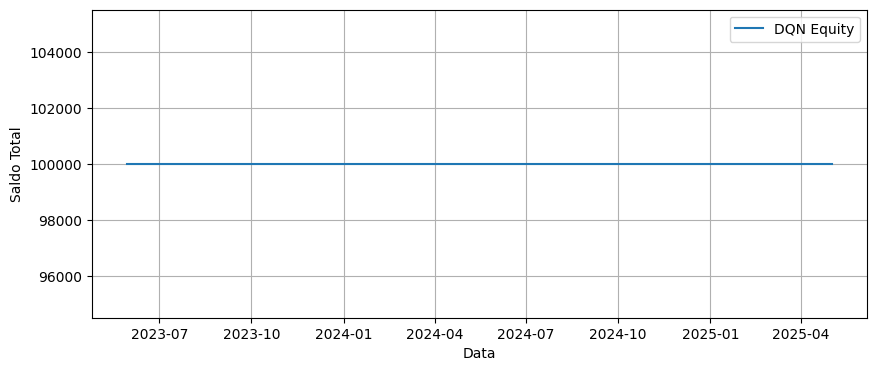

DQN: Sharpe          0.0
Max Drawdown    0.0
Num Trades      0.0
Win Rate        NaN
dtype: float64


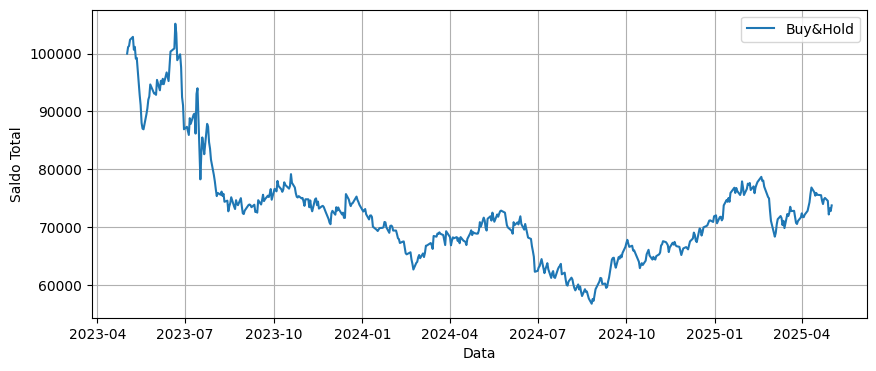

B&H: Sharpe         -0.421033
Max Drawdown   -0.460507
Num Trades      1.000000
Win Rate             NaN
dtype: float64


KeyError: 'adjclose'

In [73]:
# Colab Cell 4 — Simulação, Benchmark, Métricas e Walk-Forward

import math

# 1) Simula e coleta métricas do RL
t="ZC=F"
df_rl = simulate_trading(data_dict[t], model_dict[t])
plot_equity(df_rl,"DQN Equity")
m_rl = compute_metrics(df_rl)
print("DQN:", pd.Series(m_rl))

# 2) Simula buy-and-hold como benchmark
prices = data_dict[t]
bh = pd.DataFrame({
    "date": prices.index,
    "balance": INITIAL_BALANCE * prices/prices.iloc[0]
})
plot_equity(bh,"Buy&Hold")
rets_bh = bh["balance"].pct_change().fillna(0)
m_bh = {
    "Sharpe": rets_bh.mean()/rets_bh.std()*math.sqrt(252),
    "Max Drawdown": ((bh["balance"]-bh["balance"].cummax())/bh["balance"].cummax()).min(),
    "Num Trades": 1, "Win Rate": math.nan
}
print("B&H:", pd.Series(m_bh))

# 3) Walk-Forward com janelas menores
res=[]
train_len,test_len,step=300,100,50
sr = data_dict[t]
for start in range(0,len(sr)-train_len-test_len+1,step):
    tr=sr.iloc[start:start+train_len]
    te=sr.iloc[start+train_len:start+train_len+test_len]

    # retrain
    df2=tr.reset_index(); df2["date"]=df2["date"].astype(str).str[:10]; df2["date"]=pd.to_datetime(df2["date"])
    sr2=pd.Series(df2["adjclose"].values,index=df2["date"])
    envf=lambda:Monitor(TradingEnv(sr2))
    mdl2=DQN("MlpPolicy", make_vec_env(envf,1,seed=SEED),
             learning_rate=5e-4, buffer_size=50_000,
             learning_starts=5_000, batch_size=64,
             gamma=0.99, exploration_fraction=0.2,
             seed=SEED, verbose=0)
    mdl2.learn(total_timesteps=TOTAL_TIMESTEPS//2)

    df_t=simulate_trading(te,mdl2)
    m=compute_metrics(df_t)
    m["start"],m["end"]=tr.index[0],te.index[-1]
    res.append(m)

print("\nWalk-Forward:")
print(pd.DataFrame(res))
